## Введение в обработку естественного языка

Домашнее задание №5

Урок 5. Part-of-Speech разметка, NER, извлечение отношений

*Формат именования файла домашней работы: FIO_NLP_HW_N.ipynb, где N - номер домашнего задания*

**

**Задание 1. Написать теггер на данных с русским языком**
1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации
2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. сравнить все реализованные методы сделать выводы

In [1]:
!pip install corus
!pip install pyconll
!pip install razdel
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.1
    Uninstalling spacy-3.5.1:
      Successfully uninstalled spacy-3.5.1


In [2]:
import nltk
from nltk.tokenize import word_tokenize
import matplotlib
%matplotlib inline

from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import corus
import pandas as pd
import numpy as np

import pyconll

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-c.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2023-04-14 17:15:31--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40736581 (39M) [text/plain]
Saving to: ‘ru_syntagrus-ud-train-a.conllu’

ru_syntagrus-ud-tra 100%[===================>]  38.85M  --.-KB/s    in 0.1s    

2023-04-14 17:15:33 (346 MB/s) - ‘ru_syntagrus-ud-train-a.conllu’ saved [40736581/40736581]

--2023-04-14 17:15:33--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [6]:
pre_path = './'

full_train = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-a.conllu')
full_train_b = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-b.conllu')
full_train_c = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-c.conllu')

full_train.extend([*full_train_b, *full_train_c]) # объединяем

full_test = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-dev.conllu')

In [7]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [8]:
comparing_list = []

### Default tagger

In [9]:
%%time

default_tagger = DefaultTagger('NOUN')

# display(default_tagger.tag(fdata_sent_test[100]))
display(default_tagger.evaluate(fdata_test))

comparing_list.append(('default_tagger', default_tagger.evaluate(fdata_test)))

0.23593983983332248

CPU times: user 458 ms, sys: 7.45 ms, total: 465 ms
Wall time: 488 ms


### Unigram Tagger

In [10]:
%%time

unigram_tagger = UnigramTagger(fdata_train)

# display(unigram_tagger.tag(fdata_sent_test[100]))
display(unigram_tagger.evaluate(fdata_test))

comparing_list.append(('unigram_tagger', unigram_tagger.evaluate(fdata_test)))

0.8782863467673677

CPU times: user 3.1 s, sys: 52.8 ms, total: 3.15 s
Wall time: 3.17 s


### Bigram Tagger

In [11]:
%%time

bigram_tagger = BigramTagger(fdata_train, backoff=unigram_tagger)

# display(bigram_tagger.tag(fdata_sent_test[100]))
display(bigram_tagger.evaluate(fdata_test))

comparing_list.append(('bigram_tagger', bigram_tagger.evaluate(fdata_test)))

0.8839768214076438

CPU times: user 5.04 s, sys: 88.1 ms, total: 5.13 s
Wall time: 5.12 s


### Trigram Tagger

In [12]:
%%time

trigram_tagger = TrigramTagger(fdata_train, backoff=bigram_tagger)

# display(trigram_tagger.tag(fdata_sent_test[100]))
display(trigram_tagger.evaluate(fdata_test))

comparing_list.append(('trigram_tagger', trigram_tagger.evaluate(fdata_test)))

0.8830522820496126

CPU times: user 10.3 s, sys: 104 ms, total: 10.4 s
Wall time: 11 s


### Taggers combination

In [13]:
from nltk.tag import TrigramTagger 

def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

backoff = DefaultTagger('NOUN')

In [14]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B_T', tag.evaluate(fdata_test)))

0.9119799466111075

CPU times: user 15.9 s, sys: 41.2 ms, total: 16 s
Wall time: 16.6 s


In [15]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B', tag.evaluate(fdata_test)))

0.9118822840028648

CPU times: user 8.66 s, sys: 19.7 ms, total: 8.68 s
Wall time: 8.71 s


In [16]:
%%time

tag = backoff_tagger(fdata_train,  
                     [BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('B_T', tag.evaluate(fdata_test)))

0.8606680122403803

CPU times: user 17.3 s, sys: 64.9 ms, total: 17.3 s
Wall time: 20.6 s


In [17]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_T', tag.evaluate(fdata_test)))

0.9119213490461618

CPU times: user 9.86 s, sys: 19.6 ms, total: 9.88 s
Wall time: 10.1 s


In [18]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [19]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [20]:
test_enc_labels = le.transform(test_label)

### Count Vectorizer

In [21]:
cvtr = CountVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = cvtr.fit_transform(train_tok)
X_test = cvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('count_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8514267079732594

### Hashing Vectorizer

In [22]:
hvtr = HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=100)

X_train = hvtr.fit_transform(train_tok)
X_test = hvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('hashing_vectorizer', accuracy_score(test_enc_labels, pred)))

0.6735626936246535

### Tfidf Vectorizer

In [23]:
tfvtr = TfidfVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = tfvtr.fit_transform(train_tok)
X_test = tfvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('tfidf_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8065416598728192

In [24]:
comparing_list

[('default_tagger', 0.23593983983332248),
 ('unigram_tagger', 0.8782863467673677),
 ('bigram_tagger', 0.8839768214076438),
 ('trigram_tagger', 0.8830522820496126),
 ('U_B_T', 0.9119799466111075),
 ('U_B', 0.9118822840028648),
 ('B_T', 0.8606680122403803),
 ('U_T', 0.9119213490461618),
 ('count_vectorizer', 0.8514267079732594),
 ('hashing_vectorizer', 0.6735626936246535),
 ('tfidf_vectorizer', 0.8065416598728192)]

In [25]:
pd.DataFrame(comparing_list, columns=['tagger', 'accuracy']).sort_values(by='accuracy', ascending=False)

,tagger,accuracy
4,U_B_T,0.911980
7,U_T,0.911921
5,U_B,0.911882
2,bigram_tagger,0.883977
3,trigram_tagger,0.883052
1,unigram_tagger,0.878286
6,B_T,0.860668
8,count_vectorizer,0.851427
10,tfidf_vectorizer,0.806542
9,hashing_vectorizer,0.673563


Лучший показатель accuracy получился у комбинированного теггера, векторайзеры справились чуть хуже, ну и самый плохой показатель естественно у default_tagger.

### Задание 2. Проверить насколько хорошо работает NER
данные брать из http://www.labinform.ru/pub/named_entities/
1. проверить NER из nltk/spacy/deeppavlov
2. написать свой нер попробовать разные подходы
    * передаём в сетку токен и его соседей
    * передаём в сетку только токен
    * свой вариант
3. сравнить ваши реализованные подходы на качество (вывести precision/recall/f1_score)


In [26]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2023-04-14 17:23:15--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M  4.04MB/s    in 0.4s    

2023-04-14 17:23:16 (4.04 MB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [27]:
!unzip collection5.zip

Archive:  collection5.zip
   creating: Collection5/
  inflating: Collection5/001.ann     
  inflating: Collection5/001.txt     
  inflating: Collection5/002.ann     
  inflating: Collection5/002.txt     
  inflating: Collection5/003.ann     
  inflating: Collection5/003.txt     
  inflating: Collection5/004.ann     
  inflating: Collection5/004.txt     
  inflating: Collection5/005.ann     
  inflating: Collection5/005.txt     
  inflating: Collection5/006.ann     
  inflating: Collection5/006.txt     
  inflating: Collection5/007.ann     
  inflating: Collection5/007.txt     
  inflating: Collection5/008.ann     
  inflating: Collection5/008.txt     
  inflating: Collection5/009.ann     
  inflating: Collection5/009.txt     
  inflating: Collection5/010.ann     
  inflating: Collection5/010.txt     
  inflating: Collection5/011.ann     
  inflating: Collection5/011.txt     
  inflating: Collection5/012.ann     
  inflating: Collection5/012.txt     
  inflating: Collection5/013.ann    

In [28]:
from corus import load_ne5

path_coll5 = 'Collection5/'
records = load_ne5(path_coll5)
next(records)

Ne5Markup(
    id='292',
    text='Сергей Миронов сегодня простится с Совфедом\r\n\r\nЭкс-председатель партии "Справедливая Россия", экс-спикер Совета Федерации Сергей Миронов выступит на пленарном заседании верхней палаты российского парламента и подведет итоги своей работы на этом посту. Пост председателя Совфеда С.Миронов занял в декабре 2001г. и в течение почти десяти лет руководил работой верхней палаты.\r\n\r\nОжидается, что сенаторы отметят работу спикера государственными наградами. Не исключено, что С.Миронов удостоится звания почетного председателя Совета Федерации.\r\n\r\nНапомним, поста председателя верхней палаты С.Миронов лишился 18 мая, когда Законодательное Собрание Петербурга, от которого спикер был представлен в Совфеде, проголосовал за его отзыв. С.Миронов автоматически потерял не только кресло спикера, но и мандат сенатора.\r\n\r\nС предложением отозвать сенатора выступил спикер Заксобрания Петербурга Вадим Тюльпанов, который крайне негативно отреагировал на заявлени

In [29]:
from razdel import tokenize

In [30]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [31]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [32]:
df_words['tag'].value_counts()
df_words.head(3)

,word,tag
0,Мэра,OUT
1,Первоуральска,LOC
2,отправили,OUT


In [33]:
df_words.shape

(265204, 2)

In [34]:
records = load_ne5(path_coll5)
next(records).text
next(records).text
next(records).text
next(records).text
next(records).text
article = next(records).text
article

'РЖД официально опровергли информацию об отставке Якунина\r\n\r\n\r\nПресс-служба ОАО "РЖД" официально заявляет, что распространенная в СМИ информация о кадровых перестановках в компании не соответствует действительности.\r\n\r\n\r\nИнформацию о якобы имевшей место отставке главы РЖД, разосланную в среду вечером неизвестными лицами от имени правительственной пресс-службы, распространили все российские информагентства и другие крупнейшие СМИ, включая основные ТВ-каналы. Как установила ИТ-служба РИА Новости, сообщение, оформленное наподобие правительственного пресс-релиза и содержащее традиционные для таких документов элементы, в котором содержалась информация об отставке Якунина и якобы назначении вместо него первого вице-президента РЖД Александра Мишарина, пришло с IP-адреса, не совпадающего с адресом аппарата правительства.\r\n\r\n"Пресс-служба ОАО "РЖД" официально заявляет, что распространенная в СМИ информация о кадровых перестановках в компании не соответствует действительности", —

NLTK

In [35]:
import nltk
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [36]:
words5 = list(df_words.word)

In [37]:
data5_tag = nltk.pos_tag(words5[:50000])

In [38]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(article))) if hasattr(chunk, 'label') }

{('Наталья Тимакова', 'PERSON'),
 ('ОАО', 'ORGANIZATION'),
 ('РЖД', 'ORGANIZATION'),
 ('РЖД Александра Мишарина', 'ORGANIZATION'),
 ('РИА Новости', 'ORGANIZATION'),
 ('ФСБ', 'ORGANIZATION'),
 ('Якунин', 'PERSON'),
 ('Якунина', 'PERSON')}

NLTK справился на удивление неплохо))

Spacy

In [39]:
!python -m spacy download ru_core_news_sm

2023-04-14 17:24:44.443068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 17:24:45.492604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-14 17:24:46.769144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 17:24:46.769600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [40]:
import spacy
from spacy import displacy

In [41]:
nlp = spacy.load("ru_core_news_sm")
spacy_article = nlp(article)
displacy.render(spacy_article, jupyter=True, style='ent')

Spacy неплохо справился. А главное интересная визуализация получилась)

Deeppaclov

In [45]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [46]:
!pip install -q deeppavlov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.4/451.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [50]:
!python -m deeppavlov install ner_rus_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

In [47]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4174936 sha256=5200aed97bf88bd892af42cc09928ab601e08de3d440e37c3761507c6d8b235d
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [59]:
import deeppavlov
from deeppavlov import configs, build_model
config_path = configs.ner.ner_rus_bert
deeppavlov_ner = build_model(config_path, download=True)

2023-04-14 17:42:44.991 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/v1/ner/ner_rus_bert_torch_new.tar.gz download because of matching hashes
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPre

In [61]:
rus_document = 'РЖД официально опровергли информацию об отставке Якунина\r\n\r\n\r\nПресс-служба ОАО "РЖД" официально заявляет, что распространенная в СМИ информация о кадровых перестановках в компании не соответствует действительности.\r\n\r\n\r\nИнформацию о якобы имевшей место отставке главы РЖД, разосланную в среду вечером неизвестными лицами от имени правительственной пресс-службы, распространили все российские информагентства и другие крупнейшие СМИ, включая основные ТВ-каналы. Как установила ИТ-служба РИА Новости, сообщение, оформленное наподобие правительственного пресс-релиза и содержащее традиционные для таких документов элементы, в котором содержалась информация об отставке Якунина и якобы назначении вместо него первого вице-президента РЖД Александра Мишарина, пришло с IP-адреса, не совпадающего с адресом аппарата правительства.\r\n\r\n"Пресс-служба ОАО "РЖД" официально заявляет, что распространенная в СМИ информация о кадровых перестановках в компании не соответствует действительности", — говорится в сообщении РЖД, распространенном в среду вечером.\r\n\r\nО том, что сообщение об отставке было "уткой", заявила и пресс-секретарь премьер-министра РФ Наталья Тимакова. Эксперты ФСБ и ФСО начали проверку в связи с рассылкой фальшивого сообщения.\r\n\r\nЯкунин руководит РЖД с июня 2005 года. С инициативой о его назначении выступил президент Владимир Путин. За время своего руководства компанией Якунин провел несколько реформ в железнодорожной отрасли: почти весь парк вагонов был выведен в "дочки"; проведено IPO "Трансконтейнера"; создано несколько компаний с частными инвесторами ("Русагротранс", "Рейлтрансавто", "Русская тройка").\r\n\r\nПрезидент РЖД назначается распоряжением правительства, при этом его кандидатуру должен поддержать глава государства. В июне 2011 года Якунин был назначен главой РЖД сроком на 4 года, при этом ранее срок контракта составлял 3 года.'
deeppavlov_ner([rus_document])

[[['РЖД',
   'официально',
   'опровергли',
   'информацию',
   'об',
   'отставке',
   'Якунина',
   '\r',
   '\n',
   '\r',
   '\n',
   '\r',
   '\n',
   'Пресс',
   '-',
   'служба',
   'ОАО',
   '"',
   'РЖД',
   '"',
   'официально',
   'заявляет',
   ',',
   'что',
   'распространенная',
   'в',
   'СМИ',
   'информация',
   'о',
   'кадровых',
   'перестановках',
   'в',
   'компании',
   'не',
   'соответствует',
   'действительности',
   '.',
   '\r',
   '\n',
   '\r',
   '\n',
   '\r',
   '\n',
   'Информацию',
   'о',
   'якобы',
   'имевшей',
   'место',
   'отставке',
   'главы',
   'РЖД',
   ',',
   'разосланную',
   'в',
   'среду',
   'вечером',
   'неизвестными',
   'лицами',
   'от',
   'имени',
   'правительственной',
   'пресс',
   '-',
   'службы',
   ',',
   'распространили',
   'все',
   'российские',
   'информагентства',
   'и',
   'другие',
   'крупнейшие',
   'СМИ',
   ',',
   'включая',
   'основные',
   'ТВ',
   '-',
   'каналы',
   '.',
   'Как',
   'устан

Немного непонятно, но очень интересно. Насколько я понимаю перечислен состав токенов в указанном предложении и они разбиты по типам

Natasha

In [53]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 103.0 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=4ecf5c121aab2c4aa7d0d4abb0636bc162669982e20ffe28140a93e67dfa2c20
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
Successfully built intervaltree


In [54]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [55]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '
doc = Doc(article)

In [56]:
doc.segment(segmenter)
display(doc.tokens[:5])
display(doc.sents[:5])

[DocToken(stop=3, text='РЖД'),
 DocToken(start=4, stop=14, text='официально'),
 DocToken(start=15, stop=25, text='опровергли'),
 DocToken(start=26, stop=36, text='информацию'),
 DocToken(start=37, stop=39, text='об')]

[DocSent(stop=214, text='РЖД официально опровергли информацию об отставке ..., tokens=[...]),
 DocSent(start=220, stop=460, text='Информацию о якобы имевшей место отставке главы Р..., tokens=[...]),
 DocSent(start=461, stop=823, text='Как установила ИТ-служба РИА Новости, сообщение, ..., tokens=[...]),
 DocSent(start=827, stop=1044, text='"Пресс-служба ОАО "РЖД" официально заявляет, что ..., tokens=[...]),
 DocSent(start=1048, stop=1158, text='О том, что сообщение об отставке было "уткой", за..., tokens=[...])]

In [57]:
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
sent = doc.sents[0]
sent.morph.print()

                 РЖД PROPN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur
          официально ADV|Degree=Pos
          опровергли VERB|Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act
          информацию NOUN|Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing
                  об ADP
            отставке NOUN|Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing
             Якунина PROPN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
        Пресс-служба PROPN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing
                 ОАО NOUN|Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing
                   " PUNCT
                 РЖД NOUN|Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing
                   " PUNCT
          официально ADV|Degree=Pos
            заявляет VERB|Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act
                   , PUNCT
                 что SCONJ
    распространенная VERB|Aspect=Perf|Case=Nom|Gender=Fem|Number=Sing|Tense=Past|VerbForm=Part|Voic

In [58]:
sent.syntax.print()

              ┌──► РЖД              nsubj
              │ ┌► официально       advmod
┌─────────────└─└─ опровергли       
│           ┌─└──► информацию       obj
│           │   ┌► об               case
│         ┌─└►┌─└─ отставке         nmod
│         │   └──► Якунина          nmod
│         └────►┌─ Пресс-служба     nmod
│             ┌─└► ОАО              nmod
│             │ ┌► "                punct
│             └►└─ РЖД              appos
│             └──► "                punct
│               ┌► официально       advmod
│ ┌───────┌─────└─ заявляет         
│ │ ┌────►│        ,                punct
│ │ │ ┌──►│        что              mark
│ │ │ │   │ ┌►┌─── распространенная acl
│ │ │ │   │ │ │ ┌► в                case
│ │ │ │   │ │ └►└─ СМИ              obl
│ │ │ │ ┌─└►└───── информация       nsubj
│ │ │ │ │ │   ┌──► о                case
│ │ │ │ │ │   │ ┌► кадровых         amod
│ │ │ │ │ └──►└─└─ перестановках    nmod
│ │ │ │ │       ┌► в                case
│ │ │ │ └──────►└

In [62]:
doc.tag_ner(ner_tagger)
doc.ner.print()

РЖД официально опровергли информацию об отставке Якунина
ORG                                              PER────
Пресс-служба ОАО "РЖД" официально заявляет, что распространенная в СМИ
             ORG──────                                             ORG
 информация о кадровых перестановках в компании не соответствует 
действительности.
Информацию о якобы имевшей место отставке главы РЖД, разосланную в 
                                                ORG                
среду вечером неизвестными лицами от имени правительственной пресс-
службы, распространили все российские информагентства и другие 
крупнейшие СМИ, включая основные ТВ-каналы. Как установила ИТ-служба 
           ORG                                                       
РИА Новости, сообщение, оформленное наподобие правительственного 
ORG────────                                                      
пресс-релиза и содержащее традиционные для таких документов элементы, 
в котором содержалась информация об отставке Якун

Natasha справилась тоже довольно неплохо

## Создадим свой NER


In [63]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [64]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [65]:
train_x.apply(len).max(axis=0)

55

In [ ]:
# char level
#train_x = train_x.apply(lambda x: ' '.join(list(x)))
#valid_x = valid_x.apply(lambda x: ' '.join(list(x)))

In [66]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

### Униграмы

In [68]:
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [69]:
len(vectorize_layer.get_vocabulary())

29879

In [70]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [71]:
mmodel = modelNER()

In [72]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [73]:
mmodel.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 90s 7ms/step - loss: 0.2911 - accuracy: 0.9156 - val_loss: 0.2087 - val_accuracy: 0.9371
Epoch 2/3
12432/12432 [==============================] - 89s 7ms/step - loss: 0.1246 - accuracy: 0.9629 - val_loss: 0.2156 - val_accuracy: 0.9410
Epoch 3/3
12432/12432 [==============================] - 80s 6ms/step - loss: 0.1092 - accuracy: 0.9659 - val_loss: 0.2215 - val_accuracy: 0.9416


In [74]:
preds = mmodel.predict(valid_x)
preds = np.argmax(preds,axis=1)

2072/2072 [==============================] - 6s 3ms/step


In [75]:
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1035
           1       0.87      0.77      0.82      1183
           2       0.91      0.79      0.85       631
           3       0.89      0.55      0.68      3437
           4       0.94      0.99      0.97     54772
           5       0.98      0.72      0.83      5243

    accuracy                           0.94     66301
   macro avg       0.92      0.78      0.84     66301
weighted avg       0.94      0.94      0.94     66301



In [76]:
classes = encoder.classes_
classes

array(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'], dtype=object)

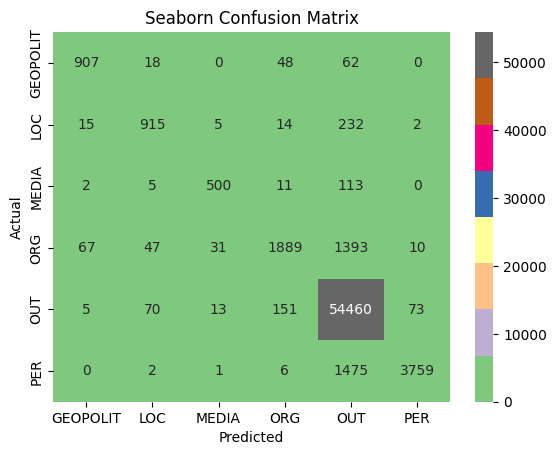

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(valid_y, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы

In [79]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 2),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_bi = modelNER()
mmodel_bi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_bi.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 93s 7ms/step - loss: 0.2908 - accuracy: 0.9152 - val_loss: 0.2098 - val_accuracy: 0.9375
Epoch 2/3
12432/12432 [==============================] - 90s 7ms/step - loss: 0.1250 - accuracy: 0.9630 - val_loss: 0.2166 - val_accuracy: 0.9399
Epoch 3/3
12432/12432 [==============================] - 87s 7ms/step - loss: 0.1094 - accuracy: 0.9658 - val_loss: 0.2182 - val_accuracy: 0.9406


2072/2072 [==============================] - 10s 5ms/step
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1035
           1       0.88      0.74      0.80      1183
           2       0.91      0.79      0.84       631
           3       0.85      0.57      0.68      3437
           4       0.94      0.99      0.97     54772
           5       0.98      0.72      0.83      5243

    accuracy                           0.94     66301
   macro avg       0.92      0.76      0.83     66301
weighted avg       0.94      0.94      0.94     66301



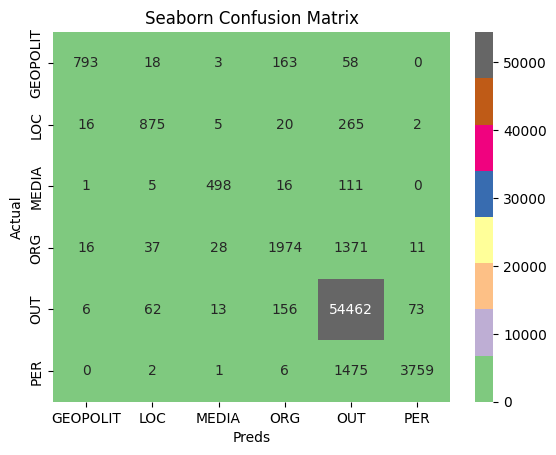

In [80]:
preds_bi = mmodel_bi.predict(valid_x)
preds_bi = np.argmax(preds_bi,axis=1)

print(classification_report(valid_y, preds_bi))

cm = confusion_matrix(valid_y, preds_bi)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Preds')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы и триграмы, и длину последовательности 100.


In [78]:
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_three = modelNER()
mmodel_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_three.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12432/12432 [==============================] - 95s 8ms/step - loss: 0.2958 - accuracy: 0.9136 - val_loss: 0.2097 - val_accuracy: 0.9376
Epoch 2/3
12432/12432 [==============================] - 89s 7ms/step - loss: 0.1254 - accuracy: 0.9628 - val_loss: 0.2238 - val_accuracy: 0.9406
Epoch 3/3
12432/12432 [==============================] - 93s 7ms/step - loss: 0.1091 - accuracy: 0.9659 - val_loss: 0.2261 - val_accuracy: 0.9410


2072/2072 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1035
           1       0.88      0.76      0.82      1183
           2       0.91      0.79      0.85       631
           3       0.85      0.57      0.68      3437
           4       0.94      0.99      0.97     54772
           5       0.98      0.72      0.83      5243

    accuracy                           0.94     66301
   macro avg       0.92      0.77      0.83     66301
weighted avg       0.94      0.94      0.94     66301



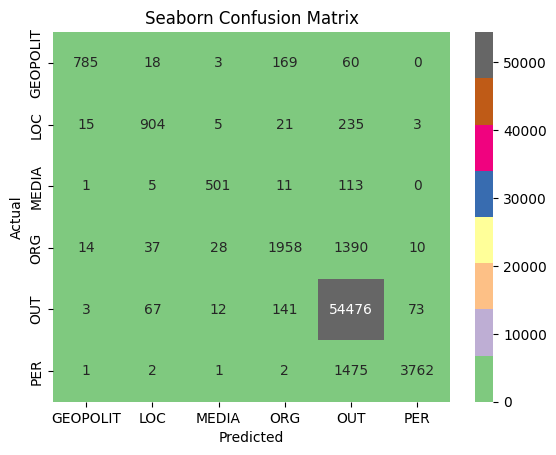

In [81]:
preds_three = mmodel_three.predict(valid_x)
preds_three = np.argmax(preds_three,axis=1)

print(classification_report(valid_y, preds_three))

cm = confusion_matrix(valid_y, preds_three)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

Самописная NER в принципе неплохо справляется. Есть небольшое улучшение, когда даем сетке токен и соседей, по сравнению с тем, когда даем сетке только токен.